In [1]:
%pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Cargar los datos
#df = pd.read_csv(r"C:\Users\ShePlay\Desktop\nuri_tiktok_dataset.csv")
df = pd.read_csv(r"/Users/marioruiz/Documents/GitHub/ML/nuri_tiktok_dataset.csv")

# Mostrar información básica
print(df.info())
print(df.describe())

# Convertir fechas a formato datetime
df['FECHA_PUBLICACION_FULL'] = pd.to_datetime(df['FECHA_PUBLICACION_FULL'])
df['FECHA'] = pd.to_datetime(df['FECHA'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marioruiz/nltk_data...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TITULO_FULL             71 non-null     object 
 1   TITULO_LIMPIO           70 non-null     object 
 2   ENLACE                  74 non-null     object 
 3   FECHA_PUBLICACION_FULL  74 non-null     object 
 4   FECHA                   74 non-null     object 
 5   HORA                    74 non-null     object 
 6   VISUALIZACIONES         74 non-null     int64  
 7   ME_GUSTA                74 non-null     int64  
 8   PORCENTAJE_LIKES        74 non-null     float64
 9   COMENTARIOS             74 non-null     int64  
 10  COMPARTIDOS             74 non-null     int64  
 11  FAVORITOS               74 non-null     int64  
 12  PORCENTAJE_FAVORITOS    74 non-null     float64
dtypes: float64(2), int64(5), object(6)
memory usage: 7.6+ KB
None
       VISUALIZACIONES     ME_GUSTA

In [3]:
# Configuración de estilo
plt.style.use('seaborn-v0_8')  # Usar la versión compatible de seaborn
# Alternativas válidas: 'ggplot', 'fivethirtyeight', 'dark_background', etc.
# Puedes ver todos los estilos disponibles con: print(plt.style.available)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [11]:
# Estadísticos clave
media = df['VISUALIZACIONES'].mean()
mediana = df['VISUALIZACIONES'].median()
moda = df['VISUALIZACIONES'].mode()[0]
max_val = df['VISUALIZACIONES'].max()

/var/folders/w1/3ck7kf7d1vj6klf2d0r05f940000gn/T/ipykernel_2809/835253716.py:27: UserWarning: Glyph 10145 (\N{BLACK RIGHTWARDS ARROW}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10145 (\N{BLACK RIGHTWARDS ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


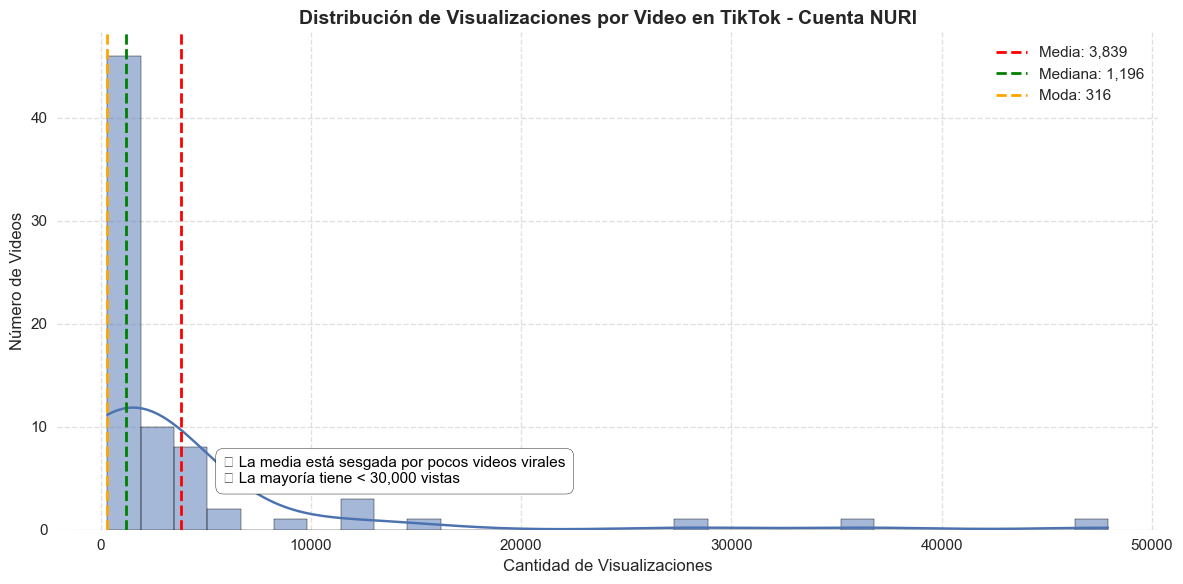

In [12]:
# Distribución de Visualizaciones en escala natural
plt.figure()

# Histograma base
sns.histplot(df['VISUALIZACIONES'], bins=30, kde=True, color='#4c72b0', edgecolor='black')

# Líneas de referencia
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {int(media):,}')
plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana: {int(mediana):,}')
plt.axvline(moda, color='orange', linestyle='--', linewidth=2, label=f'Moda: {int(moda):,}')

# Título y ejes
plt.title('Distribución de Visualizaciones por Video en TikTok - Cuenta NURI', fontsize=14, weight='bold')
plt.xlabel('Cantidad de Visualizaciones', fontsize=12)
plt.ylabel('Número de Videos', fontsize=12)

# Anotación explicativa (ideal si se presenta en PDF o slide)
plt.text(x=media + 2000, y=4.5,
         s='➡ La media está sesgada por pocos videos virales\n➡ La mayoría tiene < 30,000 vistas',
         fontsize=11, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Grid y leyenda
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()




In [ ]:
¿Qué transmite este gráfico al stakeholder?

1.El comportamiento real del canal: no todos los videos son virales, la mayoría están en un rango específico.

2.La media no es representativa de la mayoría (por lo tanto, decisiones como patrocinios o expectativas 
deben basarse en mediana).

3.Potencial identificable: Se puede estudiar qué distingue a los videos con visualizaciones mayores al promedio.

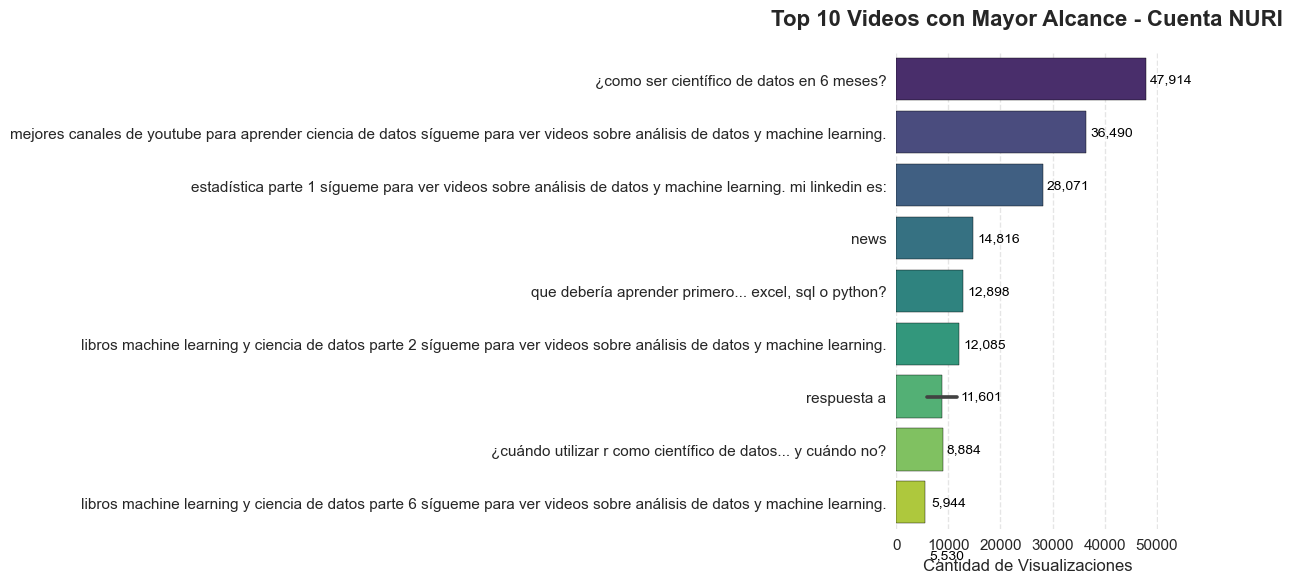

In [14]:
# 2. Top 10 videos más vistos
# Datos ordenados por visualizaciones
# Datos: top 10 más vistos
top_10 = df.sort_values('VISUALIZACIONES', ascending=False).head(10)

plt.figure(figsize=(12, 6))

# Gráfico de barras con hue y sin leyenda
sns.barplot(
    x='VISUALIZACIONES',
    y='TITULO_LIMPIO',
    hue='TITULO_LIMPIO',       # para que acepte palette sin warning
    data=top_10,
    palette='viridis',
    dodge=False,
    legend=False,
    edgecolor='black'
)

# Título (sin emoji) y configuración profesional
plt.title('Top 10 Videos con Mayor Alcance - Cuenta NURI', fontsize=16, weight='bold', pad=20)
plt.xlabel('Cantidad de Visualizaciones', fontsize=12)
plt.ylabel('')
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.grid(visible=True, axis='x', linestyle='--', alpha=0.5)

# Anotar visualizaciones al final de cada barra
for i, value in enumerate(top_10['VISUALIZACIONES']):
    plt.text(value + 800, i, f'{value:,}', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()




In [ ]:
Interpretación Estratégica

1.Alta concentración de impacto en pocos contenidos: 
solo 3 títulos concentran más del 60% de las vistas totales del top 10.

2.Contenido que combina promesa de transformación ("cómo ser científico de datos") 
con hashtags y enlaces a LinkedIn parece ser más viral.

3.Videos tipo "recomendaciones" y "tutoriales introductorios" dominan 
el ranking. Esto puede indicar que la audiencia está en etapa exploratoria.

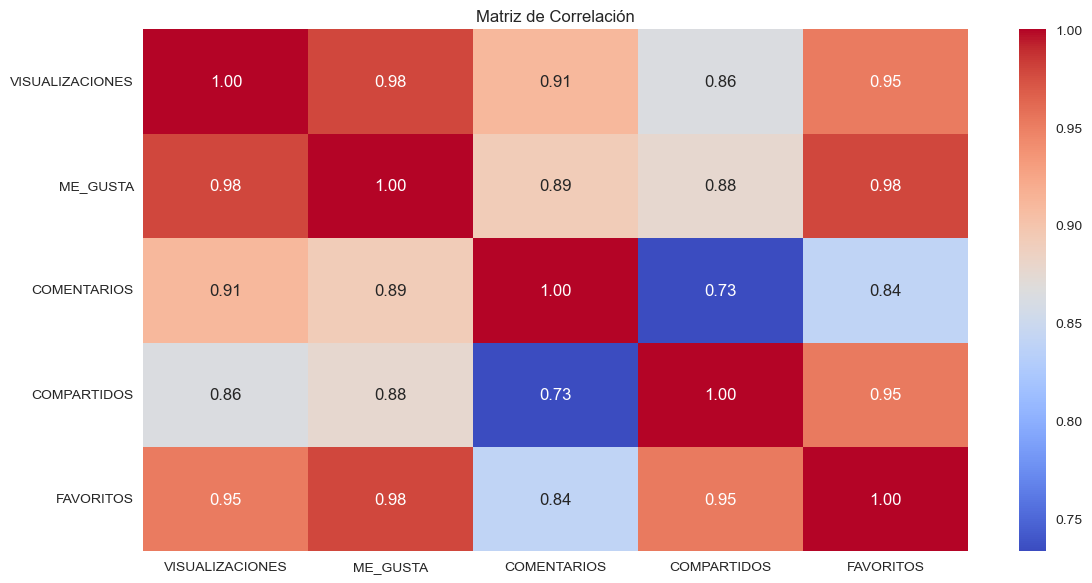

In [19]:
# 3. Correlación entre métricas
corr_matrix = df[['VISUALIZACIONES', 'ME_GUSTA', 'COMENTARIOS', 'COMPARTIDOS', 'FAVORITOS']].corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

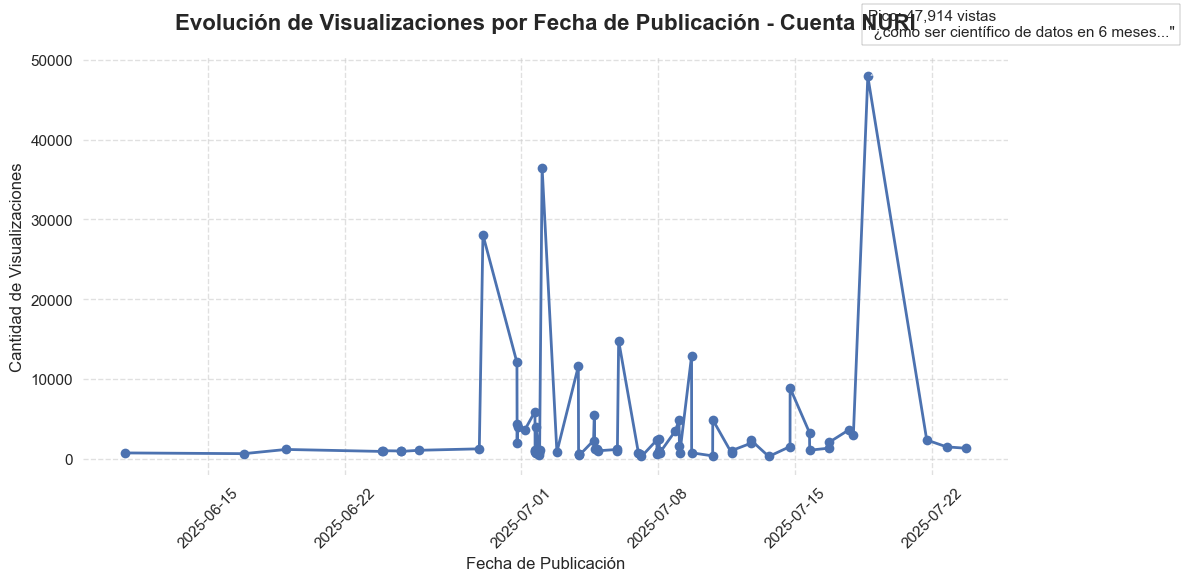

In [17]:
# 4. Evolución de visualizaciones en el tiempo
df['FECHA_PUBLICACION_FULL'] = pd.to_datetime(df['FECHA_PUBLICACION_FULL'])

# Ordenar por fecha para evitar errores visuales
df_sorted = df.sort_values('FECHA_PUBLICACION_FULL')

# Encontrar el video con más visualizaciones
max_idx = df_sorted['VISUALIZACIONES'].idxmax()
max_fecha = df_sorted.loc[max_idx, 'FECHA_PUBLICACION_FULL']
max_valor = df_sorted.loc[max_idx, 'VISUALIZACIONES']
max_titulo = df_sorted.loc[max_idx, 'TITULO_LIMPIO']

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_sorted['FECHA_PUBLICACION_FULL'],
         df_sorted['VISUALIZACIONES'],
         marker='o', linestyle='-', color='#4c72b0', linewidth=2)

# Título y etiquetas
plt.title('Evolución de Visualizaciones por Fecha de Publicación - Cuenta NURI', fontsize=16, weight='bold', pad=20)
plt.xlabel('Fecha de Publicación', fontsize=12)
plt.ylabel('Cantidad de Visualizaciones', fontsize=12)

# Estética
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Anotar el pico de visualizaciones
plt.annotate(f'Pico: {max_valor:,} vistas\n"{max_titulo[:40]}..."',
             xy=(max_fecha, max_valor),
             xytext=(max_fecha, max_valor + 5000),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=11,
             bbox=dict(facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()

/var/folders/w1/3ck7kf7d1vj6klf2d0r05f940000gn/T/ipykernel_2809/3423519930.py:34: UserWarning: Glyph 11013 (\N{LEFTWARDS BLACK ARROW}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/w1/3ck7kf7d1vj6klf2d0r05f940000gn/T/ipykernel_2809/3423519930.py:34: UserWarning: Glyph 11014 (\N{UPWARDS BLACK ARROW}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11013 (\N{LEFTWARDS BLACK ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11014 (\N{UPWARDS BLACK ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


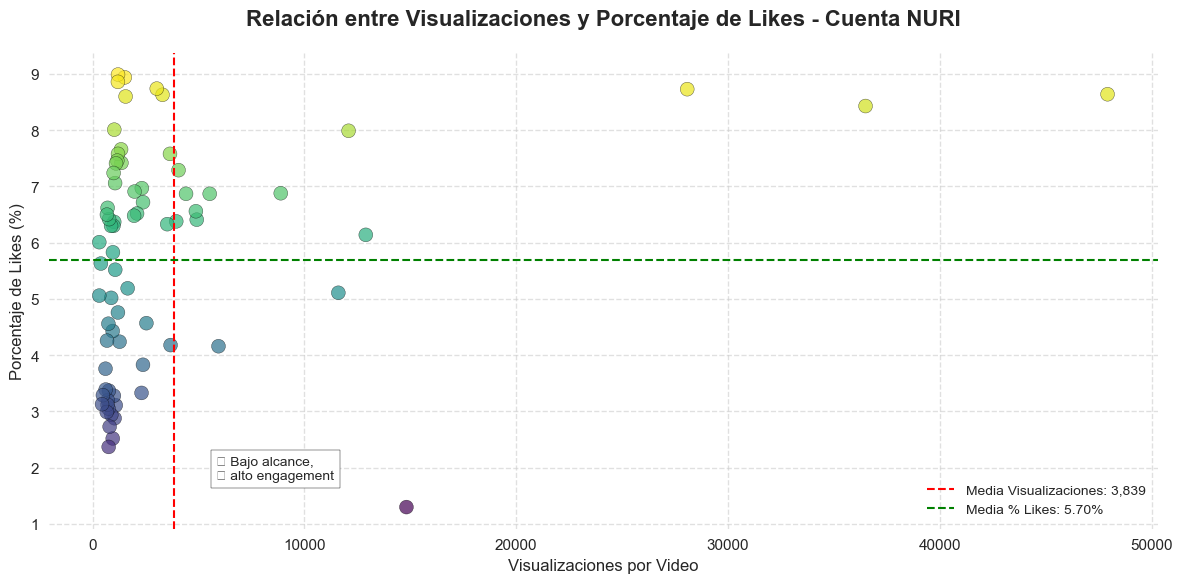

In [18]:
# 5. Porcentaje de likes vs visualizaciones
plt.figure(figsize=(12, 6))

# Gráfico base
plt.scatter(df['VISUALIZACIONES'], df['PORCENTAJE_LIKES'],
            alpha=0.7,
            c=df['PORCENTAJE_LIKES'], cmap='viridis',
            edgecolor='black', s=100)

# Título y ejes
plt.title('Relación entre Visualizaciones y Porcentaje de Likes - Cuenta NURI',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Visualizaciones por Video', fontsize=12)
plt.ylabel('Porcentaje de Likes (%)', fontsize=12)

# Estética
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Agregar líneas guía: media de cada variable
media_vistas = df['VISUALIZACIONES'].mean()
media_likes = df['PORCENTAJE_LIKES'].mean()

plt.axvline(media_vistas, color='red', linestyle='--', linewidth=1.5, label=f'Media Visualizaciones: {int(media_vistas):,}')
plt.axhline(media_likes, color='green', linestyle='--', linewidth=1.5, label=f'Media % Likes: {media_likes:.2f}%')

# Anotaciones opcionales
plt.text(media_vistas + 2000, df['PORCENTAJE_LIKES'].min() + 0.5,
         '⬅ Bajo alcance,\n⬆ alto engagement',
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


/var/folders/w1/3ck7kf7d1vj6klf2d0r05f940000gn/T/ipykernel_2809/3042728959.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['HORA'] = pd.to_datetime(df['HORA']).dt.hour


<Figure size 1200x600 with 0 Axes>

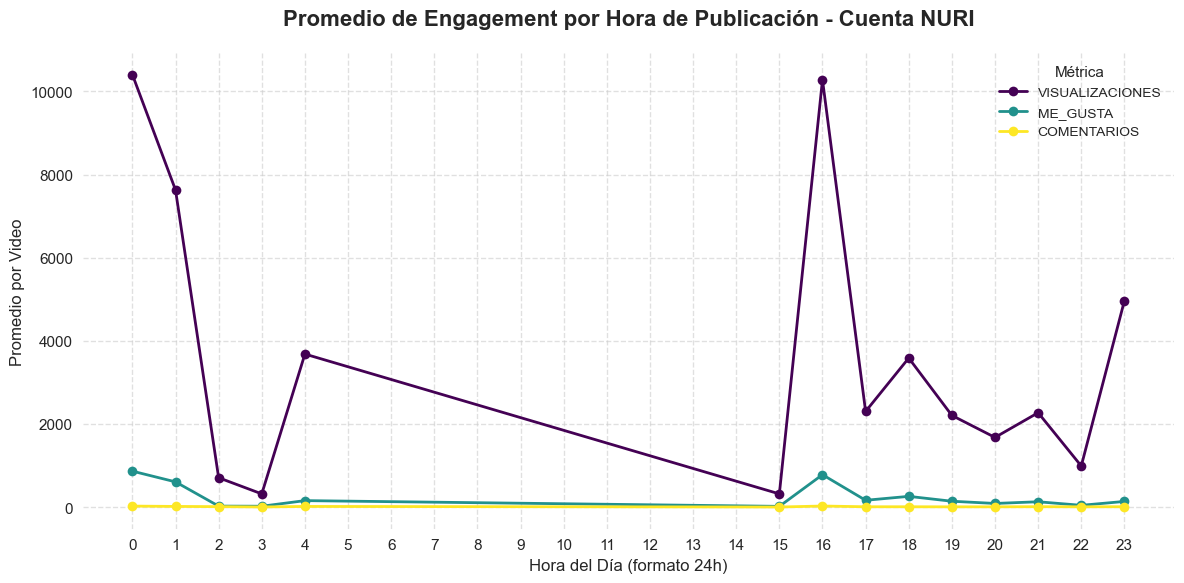

In [19]:
# 6. Hora de publicación vs engagement
# Convertir columna HORA a hora entera si no se ha hecho
df['HORA'] = pd.to_datetime(df['HORA']).dt.hour

# Agrupamiento: promedio por hora del día
engagement_by_hour = df.groupby('HORA')[['VISUALIZACIONES', 'ME_GUSTA', 'COMENTARIOS']].mean()

# Gráfico
plt.figure(figsize=(12, 6))
engagement_by_hour.plot(marker='o', linewidth=2, figsize=(12, 6), cmap='viridis')

# Título y ejes
plt.title('Promedio de Engagement por Hora de Publicación - Cuenta NURI',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Hora del Día (formato 24h)', fontsize=12)
plt.ylabel('Promedio por Video', fontsize=12)

# Estética
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(range(0, 24), fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Métrica', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


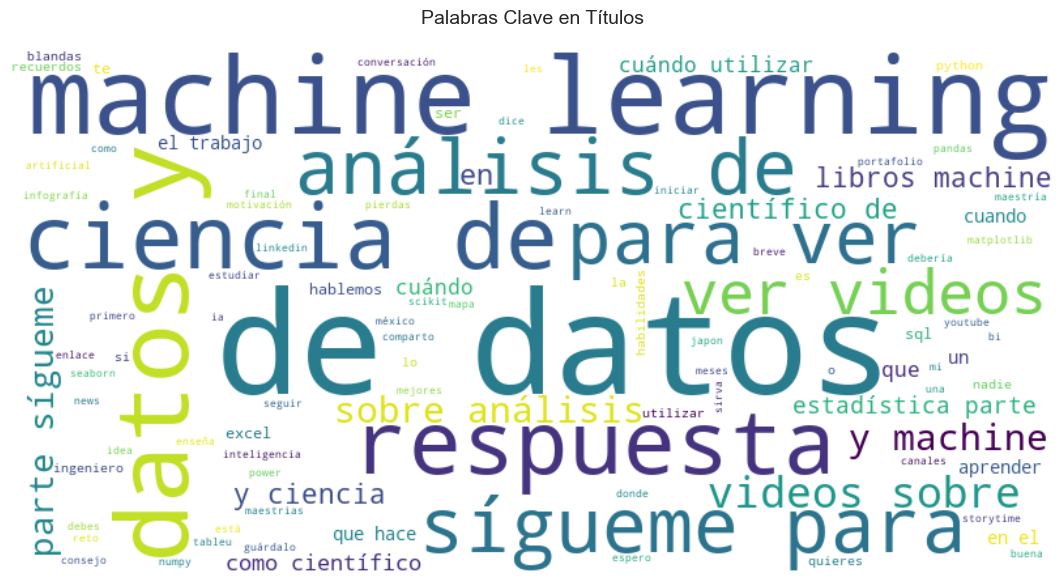

In [31]:
from collections import Counter
from wordcloud import WordCloud

# 1. Word Cloud de títulos (corregido para manejar NaN)
plt.figure(figsize=(12, 6))

# Filtrar NaN y unir títulos
all_titles = ' '.join(df['TITULO_LIMPIO'].dropna().astype(str))  # Convertir a string y eliminar NaN

# Generar y mostrar wordcloud
wordcloud = WordCloud(width=800, 
                     height=400, 
                     background_color='white',
                     colormap='viridis',  # Mejor paleta de colores
                     max_words=100).generate(all_titles)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras Clave en Títulos', pad=20, fontsize=14)
plt.tight_layout()
plt.show()

# 2. Palabras más comunes en títulos exitosos (corregido)
threshold = df['VISUALIZACIONES'].quantile(0.75)
top_titles = df[df['VISUALIZACIONES'] >= threshold]['TITULO_LIMPIO']

# Limpieza adicional: eliminar NaN y strings vacíos, convertir a minúsculas
top_words = ' '.join(top_titles.dropna().astype(str).str.lower()).split()

# Filtrar palabras vacías y de conexión
stopwords = {'de', 'en', 'y', 'la', 'el', 'los', 'las', 'que', 'para', 'con', 'del', 'se', 'por', 'como'}
filtered_words = [word for word in top_words if word not in stopwords and len(word) > 2]

word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)


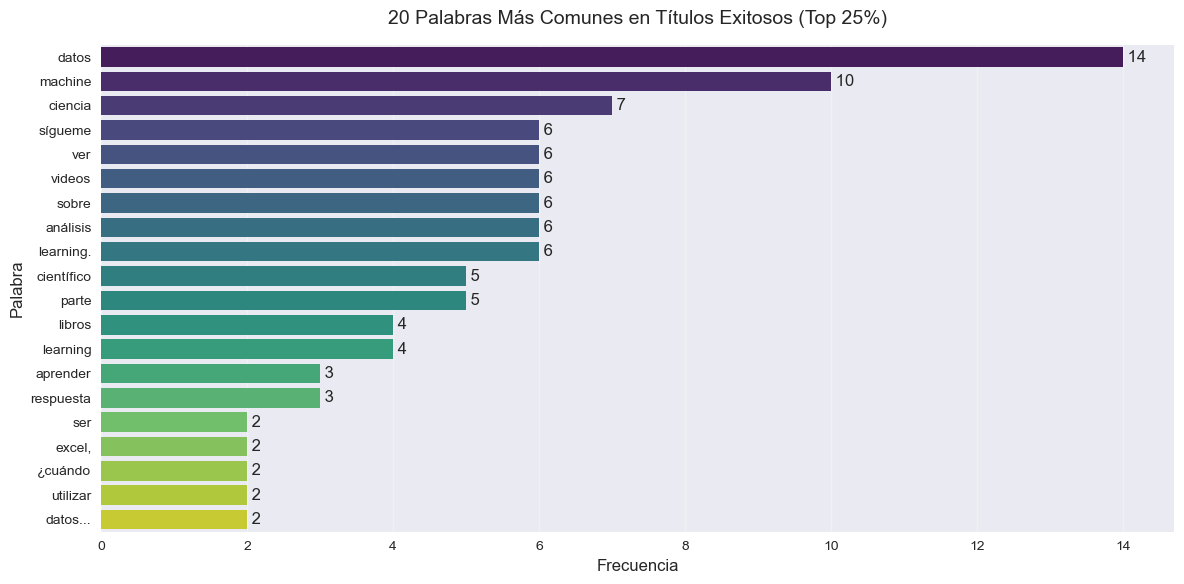

In [33]:

# Gráfico de barras mejorado
plt.figure(figsize=(12, 6))
sns.barplot(x=[count for word, count in common_words], 
            y=[word for word, count in common_words],
            hue=[word for word, count in common_words],  # Asignamos hue para usar la paleta
            palette='viridis',
            dodge=False,  # Evita separación de barras
            legend=False)  # Oculta la leyenda redundante

plt.title('20 Palabras Más Comunes en Títulos Exitosos (Top 25%)', fontsize=14, pad=15)
plt.xlabel('Frecuencia', fontsize=12)
plt.ylabel('Palabra', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Añadir los valores en las barras
for i, (word, count) in enumerate(common_words):
    plt.text(count, i, f' {count}', va='center')

plt.tight_layout()
plt.show()

In [37]:
# Extraer características de los títulos
# Primero llenamos los valores nulos con string vacío
df['TITULO_LIMPIO'] = df['TITULO_LIMPIO'].fillna('')

# Ahora podemos calcular las características
df['LONGITUD_TITULO'] = df['TITULO_LIMPIO'].str.len()
df['NUM_PALABRAS'] = df['TITULO_LIMPIO'].str.split().str.len()

# Análisis de sentimiento
sia = SentimentIntensityAnalyzer()
df['SENTIMIENTO'] = df['TITULO_LIMPIO'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Día de la semana
df['DIA_SEMANA'] = df['FECHA'].dt.dayofweek

# Codificar temas principales (versión más robusta)
temas_principales = {
    'CIENCIA_DATOS': ['ciencia de datos', 'cienciadedatos', 'datascience'],
    'MACHINE_LEARNING': ['machine learning', 'machinelearning', 'ml'],
    'PYTHON': ['python'],
    'SQL': ['sql'],
    'ESTADISTICA': ['estadística', 'estadistica'],
    'LIBROS': ['libros'],
    'TUTORIAL': ['como', 'cuándo', 'debería']
}

for tema, palabras in temas_principales.items():
    # Usamos na=False para manejar valores nulos
    df[tema] = df['TITULO_LIMPIO'].str.contains('|'.join(palabras), case=False, na=False).astype(int)

# Variable objetivo: clasificación de éxito (1 si está en el top 25% de visualizaciones)
threshold = df['VISUALIZACIONES'].quantile(0.75)
df['EXITO'] = (df['VISUALIZACIONES'] >= threshold).astype(int)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Características para el modelo
features = ['LONGITUD_TITULO', 'NUM_PALABRAS', 'SENTIMIENTO', 'DIA_SEMANA', 'HORA'] + \
           [t.upper() for t in temas_principales.keys()]
X = df[features]
y = df['EXITO']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [43]:

# Evaluar modelo
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6086956521739131

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        15
           1       0.00      0.00      0.00         8

    accuracy                           0.61        23
   macro avg       0.32      0.47      0.38        23
weighted avg       0.42      0.61      0.49        23



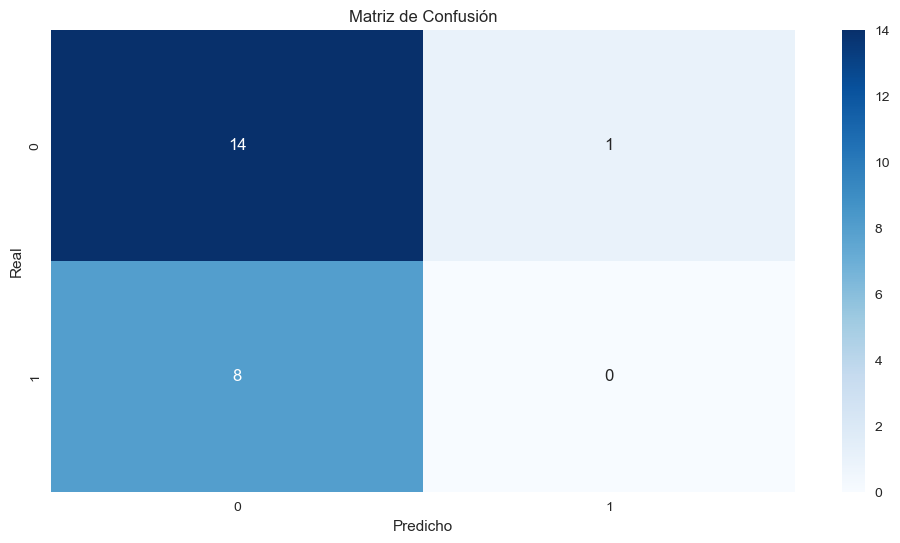

In [45]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

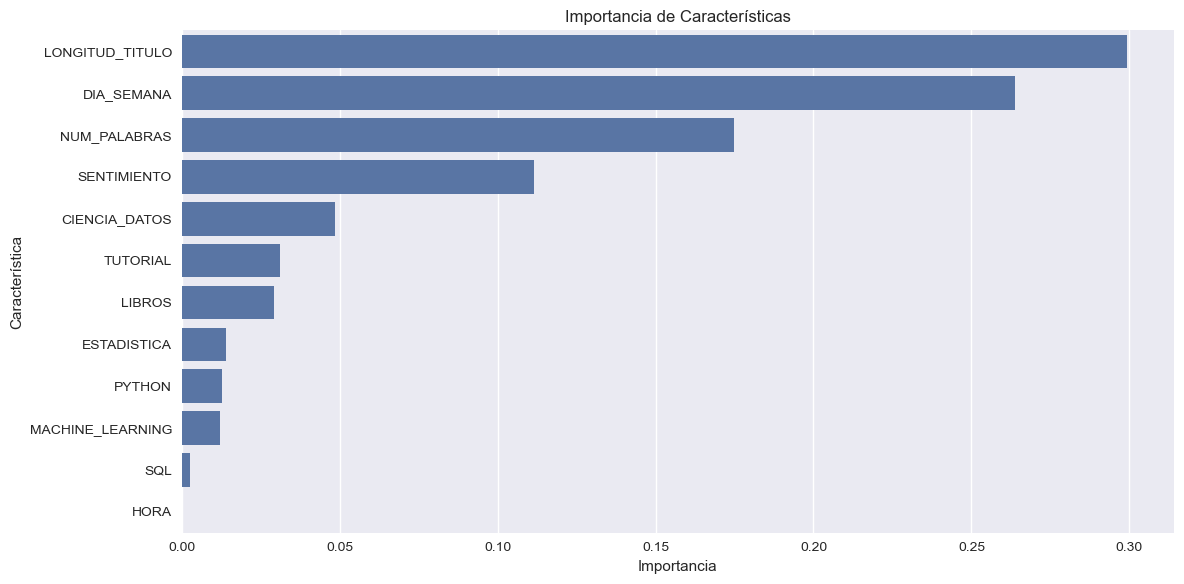

In [47]:
# Importancia de características
feature_imp = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Importancia de Características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

MSE: 1.2588755550332302
R2 Score: 0.08873519524274376


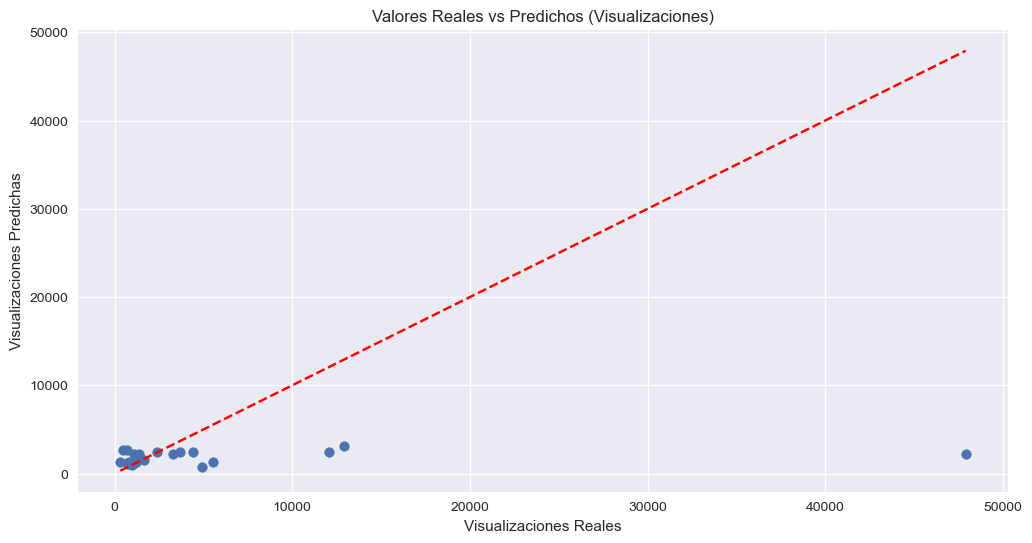

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Usar log de visualizaciones para normalizar
df['LOG_VISUALIZACIONES'] = np.log1p(df['VISUALIZACIONES'])

X = df[features]
y = df['LOG_VISUALIZACIONES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# Gráfico de valores reales vs predichos
plt.scatter(np.expm1(y_test), np.expm1(y_pred))
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], 
         [min(np.expm1(y_test)), max(np.expm1(y_test))], 'r--')
plt.title('Valores Reales vs Predichos (Visualizaciones)')
plt.xlabel('Visualizaciones Reales')
plt.ylabel('Visualizaciones Predichas')
plt.show()

GRUPO_VISUALIZACIONES
Medio (1000-10,000)      67
Alto (10,000-100,000)     7
Bajo (0-1000)             0
Name: count, dtype: int64


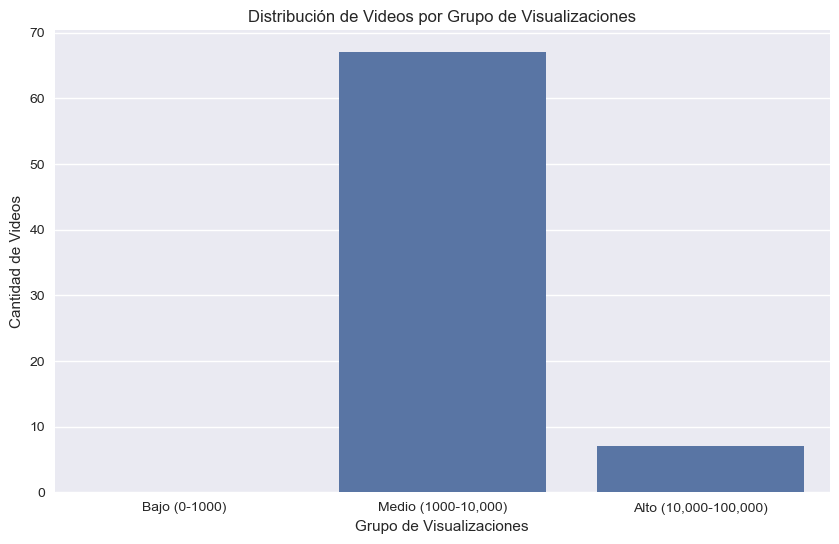

In [53]:
# Definir los grupos
bins = [0, 100, 10000, 100000]
labels = ['Bajo (0-1000)', 'Medio (1000-10,000)', 'Alto (10,000-100,000)']
df['GRUPO_VISUALIZACIONES'] = pd.cut(df['VISUALIZACIONES'], bins=bins, labels=labels, right=False)

# Mostrar distribución
group_counts = df['GRUPO_VISUALIZACIONES'].value_counts()
print(group_counts)

# Visualización
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='GRUPO_VISUALIZACIONES', order=labels)
plt.title('Distribución de Videos por Grupo de Visualizaciones')
plt.xlabel('Grupo de Visualizaciones')
plt.ylabel('Cantidad de Videos')
plt.show()

In [57]:
bajo = df[df['GRUPO_VISUALIZACIONES'] == 'Bajo (0-1000)']
print("Títulos en grupo bajo (0-1000 visualizaciones):")
print(bajo['TITULO_LIMPIO'].value_counts().head(10))

Títulos en grupo bajo (0-1000 visualizaciones):
Series([], Name: count, dtype: int64)


In [59]:
medio = df[df['GRUPO_VISUALIZACIONES'] == 'Medio (1000-10,000)']
print("\nTítulos en grupo medio (100-10,000 visualizaciones):")
print(medio['TITULO_LIMPIO'].value_counts().head(10))


Títulos en grupo medio (100-10,000 visualizaciones):
TITULO_LIMPIO
respuesta a                                                                                                                19
                                                                                                                            4
estadística parte 4 sígueme para ver videos sobre análisis de datos y machine learning.                                     1
libros machine learning y ciencia de datos parte 7 sígueme para ver videos sobre análisis de datos y machine learning.      1
libros machine learning y ciencia de datos parte 8 sígueme para ver videos sobre análisis de datos y machine learning.      1
estadística parte 1 sígueme para ver videos sobre análisis de datos y machine learning.                                     1
libros machine learning y ciencia de datos parte 10 sígueme para ver videos sobre análisis de datos y machine learning.     1
¿cuándo utilizar numpy como científico de datos...

In [61]:
alto = df[df['GRUPO_VISUALIZACIONES'] == 'Alto (10,000-100,000)']
print("\nTítulos en grupo alto (10,000-100,000 visualizaciones):")
print(alto['TITULO_LIMPIO'].value_counts().head(10))


Títulos en grupo alto (10,000-100,000 visualizaciones):
TITULO_LIMPIO
¿como ser científico de datos en 6 meses?                                                                                        1
mejores canales de youtube para aprender ciencia de datos sígueme para ver videos sobre análisis de datos y machine learning.    1
estadística parte 1 sígueme para ver videos sobre análisis de datos y machine learning. mi linkedin es:                          1
news                                                                                                                             1
que debería aprender primero... excel, sql o python?                                                                             1
libros machine learning y ciencia de datos parte 2 sígueme para ver videos sobre análisis de datos y machine learning.           1
respuesta a                                                                                                                      1
Name: count,

In [63]:
# Crear métrica de engagement ponderada
df['ENGAGEMENT'] = (df['ME_GUSTA'] * 0.4 + df['COMENTARIOS'] * 0.3 + 
                    df['COMPARTIDOS'] * 0.2 + df['FAVORITOS'] * 0.1)

# Normalizar por visualizaciones
df['ENGAGEMENT_RATE'] = df['ENGAGEMENT'] / df['VISUALIZACIONES']

# Análisis por grupo
engagement_stats = df.groupby('GRUPO_VISUALIZACIONES')[['ENGAGEMENT', 'ENGAGEMENT_RATE']].mean()
print(engagement_stats)

                       ENGAGEMENT  ENGAGEMENT_RATE
GRUPO_VISUALIZACIONES                             
Bajo (0-1000)                 NaN              NaN
Medio (1000-10,000)     50.432836         0.025784
Alto (10,000-100,000)  862.071429         0.032251


C:\Users\ShePlay\AppData\Local\Temp\ipykernel_4308\2225435118.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_stats = df.groupby('GRUPO_VISUALIZACIONES')[['ENGAGEMENT', 'ENGAGEMENT_RATE']].mean()


In [65]:
top_bajo = bajo.sort_values('ENGAGEMENT_RATE', ascending=False).head(5)
print("\nTop 5 videos en grupo bajo por engagement rate:")
print(top_bajo[['TITULO_LIMPIO', 'VISUALIZACIONES', 'ENGAGEMENT', 'ENGAGEMENT_RATE']])

KeyError: 'ENGAGEMENT_RATE'

In [67]:
top_medio = medio.sort_values('ENGAGEMENT_RATE', ascending=False).head(5)
print("\nTop 5 videos en grupo medio por engagement rate:")
print(top_medio[['TITULO_LIMPIO', 'VISUALIZACIONES', 'ENGAGEMENT', 'ENGAGEMENT_RATE']])

KeyError: 'ENGAGEMENT_RATE'

In [69]:
top_alto = alto.sort_values('ENGAGEMENT_RATE', ascending=False).head(5)
print("\nTop 5 videos en grupo alto por engagement rate:")
print(top_alto[['TITULO_LIMPIO', 'VISUALIZACIONES', 'ENGAGEMENT', 'ENGAGEMENT_RATE']])

KeyError: 'ENGAGEMENT_RATE'


Análisis de clusters de engagement:
            ME_GUSTA  COMENTARIOS  COMPARTIDOS    FAVORITOS
CLUSTER                                                    
0         171.152778         7.25     9.763889    69.555556
1        3075.000000        46.00   791.000000  2524.000000
2        4138.000000       105.00   508.000000  2436.000000


C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


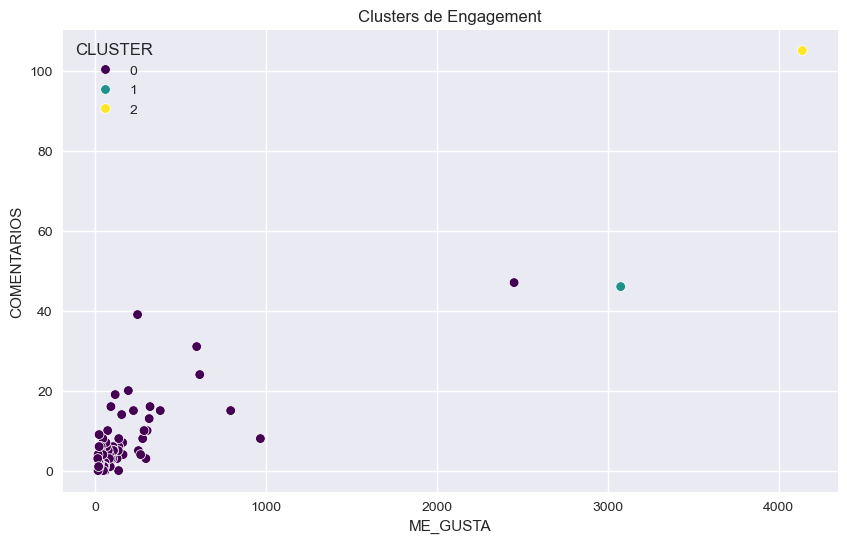

In [71]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Preparar datos para clustering
engagement_data = df[['ME_GUSTA', 'COMENTARIOS', 'COMPARTIDOS', 'FAVORITOS']]
engagement_data = engagement_data[engagement_data['ME_GUSTA'] > 0]  # Eliminar ceros

# Escalar datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(engagement_data)

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Añadir clusters al dataframe
engagement_data['CLUSTER'] = clusters

# Analizar clusters
cluster_analysis = engagement_data.groupby('CLUSTER').mean()
print("\nAnálisis de clusters de engagement:")
print(cluster_analysis)

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ME_GUSTA', y='COMENTARIOS', hue='CLUSTER', data=engagement_data, palette='viridis')
plt.title('Clusters de Engagement')
plt.show()

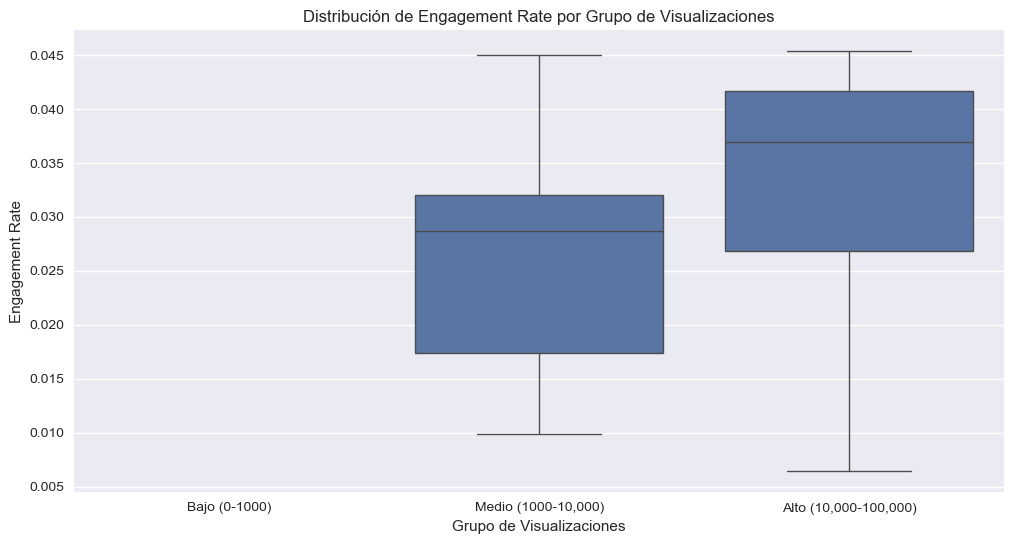

In [75]:
# Gráfico de caja para engagement rate por grupo
plt.figure(figsize=(12, 6))
sns.boxplot(x='GRUPO_VISUALIZACIONES', y='ENGAGEMENT_RATE', data=df, order=labels)
plt.title('Distribución de Engagement Rate por Grupo de Visualizaciones')
plt.xlabel('Grupo de Visualizaciones')
plt.ylabel('Engagement Rate')
plt.show()


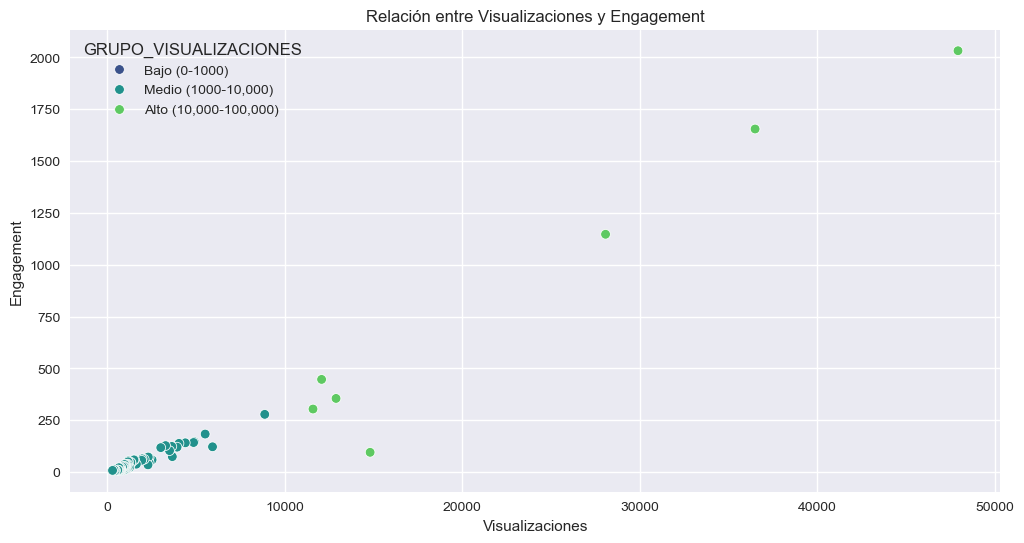

In [77]:

# Gráfico de dispersión: visualizaciones vs engagement
plt.figure(figsize=(12, 6))
sns.scatterplot(x='VISUALIZACIONES', y='ENGAGEMENT', hue='GRUPO_VISUALIZACIONES', data=df, palette='viridis')
plt.title('Relación entre Visualizaciones y Engagement')
plt.xlabel('Visualizaciones')
plt.ylabel('Engagement')
plt.show()


In [87]:
# Wordcloud por grupo
def plot_wordcloud_by_group(group):
    titles = ' '.join(group['TITULO_LIMPIO'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(titles)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Palabras Clave en Grupo {group.name}')
    plt.show()

In [83]:

# Aplicar a cada grupo
for name, group in df.groupby('GRUPO_VISUALIZACIONES'):
    plot_wordcloud_by_group(group)

C:\Users\ShePlay\AppData\Local\Temp\ipykernel_4308\2395309235.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('GRUPO_VISUALIZACIONES'):


ValueError: We need at least 1 word to plot a word cloud, got 0.